# Formula 1 driver performance comparison

At every race, drivers have to complete a qualifying lap on Saturday and race on the next day. Qualifying result will determine the position of the grid for the race. This analysis will serve the function to observe the relationship between the two-day results.

This analysis will use Formula 1 API from [Ergast](https://ergast.com/mrd/)

In [115]:
import requests as re
import pandas as pd
import json
import numpy as np
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
main_df = pd.DataFrame()
data = []

for i in range(1,21):
    url = "https://ergast.com/api/f1/2021/qualifying/" + str(i) + ".json"
    response = re.get(url)
    json = response.json()
    df = json_normalize(json['MRData']['RaceTable']['Races'])
    drivers = []
    for j in json['MRData']['RaceTable']['Races']:
        for k in j['QualifyingResults']:
            drivers.append(k['Driver']['code'])
    df['QualifyingResults'] = drivers
    df['position'] = i
    data.append(df)

main_df = main_df.append(data, True)

In [4]:
main_df = main_df[['round', 'raceName', 'QualifyingResults', 'position']]
main_df.head()

,round,raceName,QualifyingResults,position
0,1,Bahrain Grand Prix,VER,1
1,2,Emilia Romagna Grand Prix,HAM,1
2,3,Portuguese Grand Prix,BOT,1
3,4,Spanish Grand Prix,HAM,1
4,5,Monaco Grand Prix,LEC,1


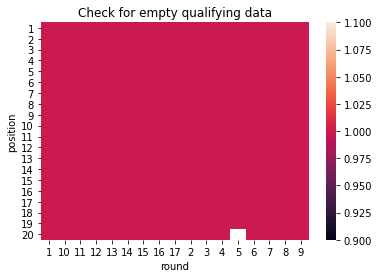

In [5]:
pivot = pd.pivot_table(main_df, values='QualifyingResults', index=['position'], columns=['round'], aggfunc='count')
ax = sns.heatmap(pivot)
ax.set_title('Check for empty qualifying data');

## Get race positions
[to do]

In [6]:
race_df = pd.DataFrame()
data = []

for i in range(1,21):
    url = "http://ergast.com/api/f1/2021/results/" + str(i) + ".json"
    response = re.get(url)
    json = response.json()
    df = json_normalize(json['MRData']['RaceTable']['Races'])
    drivers = []
    for j in json['MRData']['RaceTable']['Races']:
        for k in j['Results']:
            drivers.append(k['Driver']['code'])
    df['Results'] = drivers
    df['position'] = i
    data.append(df)

race_df = race_df.append(data, True)

In [7]:
race_df = race_df[['round', 'raceName', 'Results', 'position']]
race_df.head()

,round,raceName,Results,position
0,1,Bahrain Grand Prix,HAM,1
1,2,Emilia Romagna Grand Prix,VER,1
2,3,Portuguese Grand Prix,HAM,1
3,4,Spanish Grand Prix,HAM,1
4,5,Monaco Grand Prix,VER,1


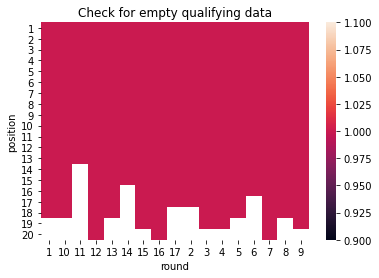

In [8]:
pivot = pd.pivot_table(race_df, values='Results', index=['position'], columns=['round'], aggfunc='count')
ax = sns.heatmap(pivot)
ax.set_title('Check for empty qualifying data');

## Merge the two tables
[to do]

In [9]:
# renaming columns
main_df.rename(columns={'QualifyingResults':'driver', 'position': 'quali_pos'}, inplace=True)
race_df.rename(columns={'Results':'driver', 'position': 'race_pos'}, inplace=True)

In [10]:
main_df['to_match'] = main_df[['round', 'driver']].agg('-'.join, axis=1)
main_df.head()

,round,raceName,driver,quali_pos,to_match
0,1,Bahrain Grand Prix,VER,1,1-VER
1,2,Emilia Romagna Grand Prix,HAM,1,2-HAM
2,3,Portuguese Grand Prix,BOT,1,3-BOT
3,4,Spanish Grand Prix,HAM,1,4-HAM
4,5,Monaco Grand Prix,LEC,1,5-LEC


In [11]:
race_df['to_match'] = race_df[['round', 'driver']].agg('-'.join, axis=1)
race_df.head()

,round,raceName,driver,race_pos,to_match
0,1,Bahrain Grand Prix,HAM,1,1-HAM
1,2,Emilia Romagna Grand Prix,VER,1,2-VER
2,3,Portuguese Grand Prix,HAM,1,3-HAM
3,4,Spanish Grand Prix,HAM,1,4-HAM
4,5,Monaco Grand Prix,VER,1,5-VER


In [64]:
main_df = main_df.merge(race_df[['to_match','race_pos']],how='left',on='to_match')
main_df.head()

,round,raceName,driver,quali_pos,to_match,race_pos_x,race_pos_y,race_pos_x,race_pos_y,race_pos
0,1,Bahrain Grand Prix,VER,1,1-VER,2.0,2.0,2.0,2.0,2.0
1,2,Emilia Romagna Grand Prix,HAM,1,2-HAM,2.0,2.0,2.0,2.0,2.0
2,3,Portuguese Grand Prix,BOT,1,3-BOT,3.0,3.0,3.0,3.0,3.0
3,4,Spanish Grand Prix,HAM,1,4-HAM,1.0,1.0,1.0,1.0,1.0
4,5,Monaco Grand Prix,LEC,1,5-LEC,NaN,NaN,NaN,NaN,NaN


## Export to csv or chart scatter plot of all data
[to do]

In [65]:
# main_df.to_csv('plot.csv')

In [87]:
main_df.dtypes

round          object
raceName       object
driver         object
quali_pos       int64
to_match       object
race_pos_x    float64
race_pos_y    float64
race_pos_x    float64
race_pos_y    float64
race_pos      float64
dtype: object

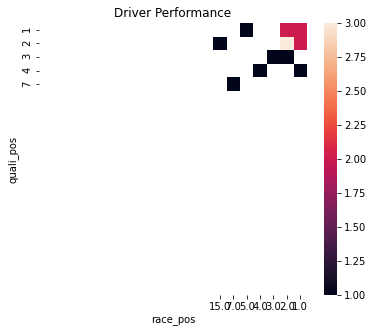

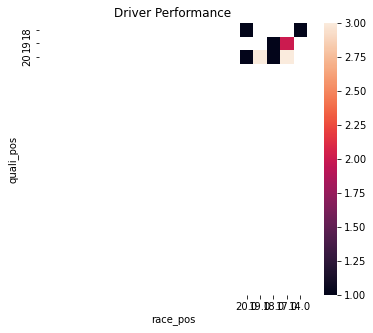

In [219]:
chart_list = ['HAM', 'MAZ']

for item in chart_list:
    pivot = pd.pivot_table(main_df.loc[main_df['driver']==item], values='round', index=['quali_pos'], columns=['race_pos'], aggfunc='count')
    fig = plt.figure(i, figsize=(6,5))
    ax = sns.heatmap(pivot)
    ax.set(title = 'Driver Performance',
        xlim =(0, 20), 
        ylim =(0, 20),
        autoscale_on = False)
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.show()

In [220]:
pivot

race_pos,14.0,17.0,18.0,19.0,20.0
quali_pos,,,,,
18,1.0,NaN,NaN,NaN,1.0
19,NaN,2.0,1.0,NaN,NaN
20,NaN,3.0,1.0,3.0,1.0
